[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

Code here follows the [TensorFlow](https://www.tensorflow.org/) implementation by Mark Chang found [here](https://github.com/ckmarkoh/neuralart_tensorflow).

The key idea of the paper is that representations of image style and content may both be found in the activations of layers in a convolutional neural network and these representations are _separable_. That is we manipulate them independently. The authors speculate about biological analogs to the mechanisms they employ here and argue that the perceptual ability to see and appreciate style is a necessary consequence of being able to visually process images into high-level representations of _content_ (as opposed to collections of unordered colors and edges).

In [1]:
from __future__ import print_function
from __future__ import division
import tensorflow as tf
import numpy as np
import scipy.io
import scipy.misc
from skimage.transform import resize
from tensorflow.python.framework import ops
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
vggmodelfile = 'imagenet-vgg-verydeep-19.mat'
if not os.path.isfile(os.path.join('.', vggmodelfile)):
    import six.moves.urllib.request as request
    # use `dl=1` as part of query to force a download
    origin = ('https://www.dropbox.com/s/qy9gikdpuq95w8n/%s?dl=1' % vggmodelfile)
    print('Downloading VGG16 model from: %s' % origin)
    request.urlretrieve(origin, vggmodelfile)
else:
    print('VGG19 model', vggmodelfile, 'is available.')

VGG19 model imagenet-vgg-verydeep-19.mat is available.


In [4]:
out_dir = './results'
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [5]:
image_dir = './images'

#style_image = 'impressionist.jpg'
#style_image = 'monet_lilly.jpg'
style_image = 'cezanne1.jpg'

#source_image = 'MALcloudGate2560x1600.jpg'
#source_image = 'Taipei101.jpg'
#source_image = 'mars.jpg'
#source_image = 'iPhone.jpg'
source_image = 'fermilab-scenes.jpg'

source = os.path.join(image_dir, source_image)
style = os.path.join(image_dir, style_image)

if os.path.isdir(image_dir):
    print('Image directory is ready...')
else:
    os.makedirs(image_dir)
        
if os.path.exists(source):
    print('Source image exists...')
else:
    import six.moves.urllib.request as request
    origin = ('https://www.dropbox.com/s/9cosz20ijl4xerm/%s?dl=1' % source_image)
    print('Downloading source image from: %s' % origin)
    request.urlretrieve(origin, source)

if os.path.exists(style):
    print('Style image exists...')
else:
    import six.moves.urllib.request as request
    origin = ('https://www.dropbox.com/s/8frdjcgf7vnjosx/%s?dl=1' % style_image)
    print('Downloading style image from: %s' % origin)
    request.urlretrieve(origin, style)

Image directory is ready...
Source image exists...
Style image exists...


In [13]:
IMAGE_W = 800   # 1.333 aspect ratio
IMAGE_H = 600
VGG_MEAN_VALUES = np.array([123, 117, 104]).reshape((1,1,1,3))

In [14]:
def imshow_clean(img, interpolation=None):
    fig = plt.figure()
    ax = plt.gca()
    ax.axis('off')
    im = ax.imshow(img, interpolation=interpolation)
    return im

In [15]:
def show_img_pair(raw, normed, 
                  raw_title='Raw Image', normed_title='Normalized Image', interpolation=None,
                  raw_type='uint8', normed_type='int8'):
    """
    use this method to display raw and normalized images by default, but can just show pairs generally
    """
    show_norm = normed
    if len(normed.shape) == 4:
        show_norm = normed[0]
    
    fig = plt.figure(figsize=(22,12))
    gs = plt.GridSpec(1, 2)
    ax = plt.subplot(gs[0])
    ax.axis('off')
    im = ax.imshow(raw.astype(raw_type), interpolation=interpolation)
    plt.title(raw_title + ': {} x {}'.format(raw.shape[0],raw.shape[1]))
    ax = plt.subplot(gs[1])
    ax.axis('off')
    im = ax.imshow(show_norm.astype(normed_type), interpolation=interpolation)
    plt.title(normed_title + ': {} x {}'.format(show_norm.shape[0],show_norm.shape[1]))

In [16]:
def crop_by_aspectr(img, aspect_ratio=1.3333, tolerance=0.01):
    """
    * if too tall, remove segments from top and bottom
    * if too wide, remove segments from left and right
    """
    if aspect_ratio <= 1 or img.shape[0] == img.shape[1]:
        print('this function is set up for images wider than they are tall')
        cropped_img = img[:, :, :]
        return cropped_img
    img_shape = img.shape
    taller_than_wide = img_shape[0] > img_shape[1]
    if taller_than_wide:
        new_h = int(img_shape[1] / aspect_ratio)
        extra = int((img_shape[0] - new_h) / 2)
        cropped_img = img[extra: new_h + extra, :, :]
    else:
        new_w = int(img_shape[0] * aspect_ratio)
        extra = int((img_shape[1] - new_w) / 2)
        cropped_img = img[:, extra: new_w + extra, :]
    return cropped_img

In [17]:
def resizer(img, imgh=600, imgw=800, scale=255):
    """
    here, the default scale assumes we are rescaling for uint8 (8 bits expected by VGG); if you have to 
    `resize` an image, the elements are re-scaled into the range $[0, 1]$. Be careful to scale back to 
    0 to 255.
    """
    img_shape = img.shape
    if len(img_shape) == 2:
        img_resized = scale * resize(img, (imgh, imgw))
    elif len(img_shape) == 3:
        img_resized = scale * resize(img, (imgh, imgw, 3))
    else:
        print('invalid image dimensions, image shape =', img_shape)
        
    return img_resized

In TensorFlow, image tensor shapes should be : `N x H x W x NChannels`. We will be using a pre-trained VGG16 model here, so we need to resize our images appropriately. In order to use the VGG model, we will also need to subtract the mean of the training dataset for that model.

In [18]:
def tensorfy_and_normalize(img, mean_values=VGG_MEAN_VALUES):
    img_shape = img.shape
    assert(len(img_shape) == 3)   # we need rgb images to work with VGG anyway
    img_resized = img[np.newaxis, :, :, :]
    img_normalized = img_resized - mean_values
    return img_normalized

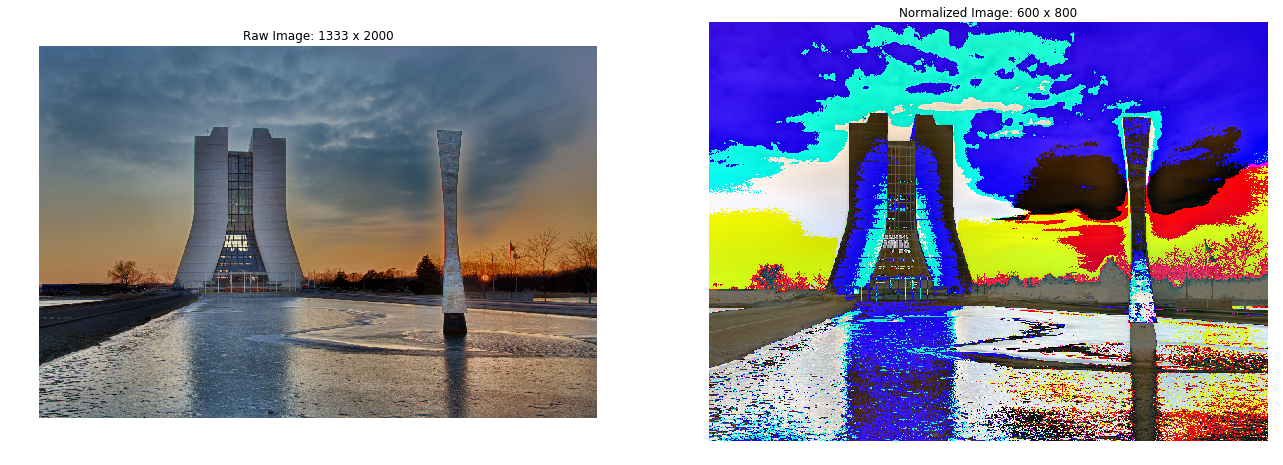

In [19]:
#source_image = 'MALcloudGate2560x1600.jpg'
#source_image = 'Taipei101.jpg'
#source_image = 'mars.jpg'
#source_image = 'iPhone.jpg'
source_image = 'fermilab-scenes.jpg'

source = os.path.join(image_dir, source_image)

raw_source = plt.imread(source)
cropped_source = crop_by_aspectr(raw_source)
resized_source = resizer(cropped_source)
normed_source = tensorfy_and_normalize(resized_source)
show_img_pair(raw_source, normed_source)

As a sanity check, let's be sure that if we add the `VGG_MEAN_VALUES` back, we get the image we expect:

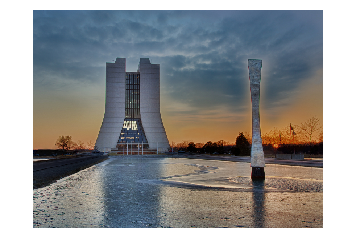

In [20]:
imshow_clean((normed_source + VGG_MEAN_VALUES)[0].astype('uint8'))

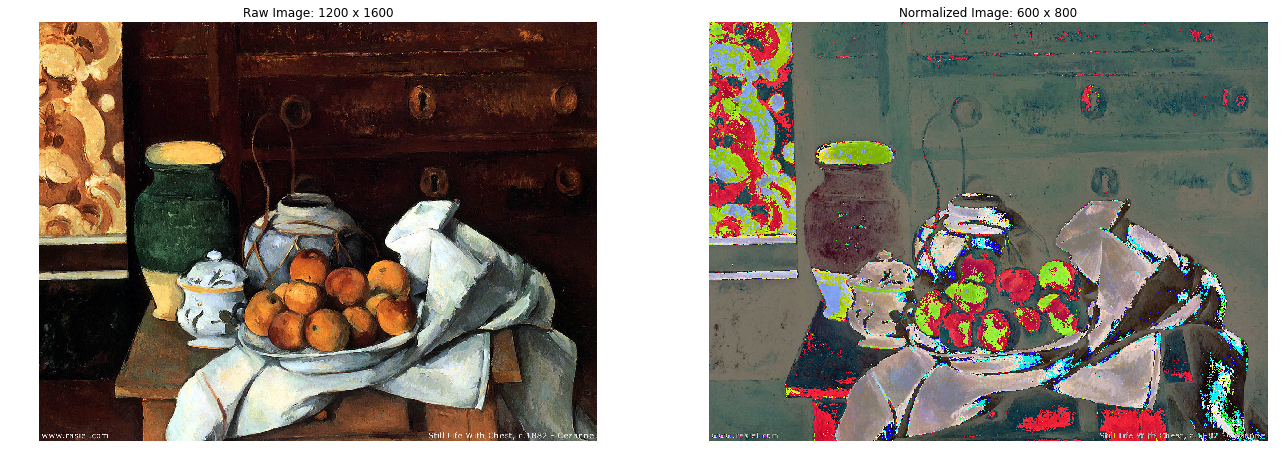

In [21]:
style_image = 'monet_lilly.jpg'
style_image = 'cezanne1.jpg'

style = os.path.join(image_dir, style_image)

raw_style = plt.imread(style)
cropped_style = crop_by_aspectr(raw_style)
resized_style = resizer(cropped_style)
normed_style = tensorfy_and_normalize(resized_style)
show_img_pair(raw_style, normed_style)

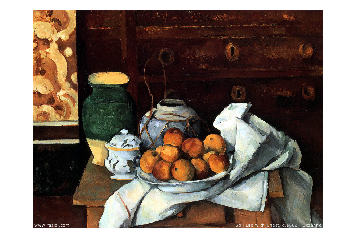

In [22]:
imshow_clean((normed_style + VGG_MEAN_VALUES)[0].astype('uint8'))

In [23]:
# rename for convenience / simplicity
source_img = normed_source
style_img = normed_style

In [24]:
CONTENT_LAYERS = [('conv4_2', 1.)]
STYLE_LAYERS = [('conv1_1', 1.), ('conv2_1', 1.), ('conv3_1', 1.), ('conv4_1', 1.), ('conv5_1', 1.)]

In [26]:
def build_net(ntype, nin, rwb=None):
    """
    utility function for building network layers
    * ntype == network layer type
    * nin == network input layer
    * rwb == weights and biases
    """
    # `strides` basically describe how far the kernel steps in each tensor dimension
    # `ksize` describes the size of the pooling region
    # If we use `SAME` padding, the filter is allowed to go off the edge by half the filter size on each side,
    # so we would expect an unchanged image size with stride=1 and a (1/2)x(1/2) for stride=2.
    if ntype == 'conv':
        return tf.nn.relu(tf.nn.conv2d(nin, rwb[0], strides=[1, 1, 1, 1], padding='SAME') + rwb[1])
    elif ntype == 'pool':
        return tf.nn.avg_pool(nin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Padding is explained in the TF [documentation for convolution](https://www.tensorflow.org/api_docs/python/nn/convolution#convolution). 

Let's demonstrate it with the pooling operation:

In [27]:
# X shape of None x 6 x 6 x 1 -> any number of 6x6 tensors that are "1-deep" (e.g., grayscale)
X = tf.placeholder(tf.float32, shape=(None, 6, 6, 1), name='X')
Y_same = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
Y_valid = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

TensorFlow separates graph definition and computation into two steps - we must execute operations within a _Session_.

In [28]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

We need to pass a tensor with actual data into our "graph" to see how it works.

In [29]:
X_vals = np.arange(6*6).reshape(1, 6, 6, 1)
print(X_vals)

[[[[ 0]
   [ 1]
   [ 2]
   [ 3]
   [ 4]
   [ 5]]

  [[ 6]
   [ 7]
   [ 8]
   [ 9]
   [10]
   [11]]

  [[12]
   [13]
   [14]
   [15]
   [16]
   [17]]

  [[18]
   [19]
   [20]
   [21]
   [22]
   [23]]

  [[24]
   [25]
   [26]
   [27]
   [28]
   [29]]

  [[30]
   [31]
   [32]
   [33]
   [34]
   [35]]]]


In [30]:
Y_same_vals = sess.run(Y_same, feed_dict={X: X_vals})
print(Y_same_vals.shape)
print(Y_same_vals)

(1, 3, 3, 1)
[[[[  3.5]
   [  5.5]
   [  7.5]]

  [[ 15.5]
   [ 17.5]
   [ 19.5]]

  [[ 27.5]
   [ 29.5]
   [ 31.5]]]]


In [31]:
Y_valid_vals = sess.run(Y_valid, feed_dict={X: X_vals})
print(Y_valid_vals.shape)
print(Y_valid_vals)

(1, 3, 3, 1)
[[[[  3.5]
   [  5.5]
   [  7.5]]

  [[ 15.5]
   [ 17.5]
   [ 19.5]]

  [[ 27.5]
   [ 29.5]
   [ 31.5]]]]


In [32]:
ops.reset_default_graph()

<img src='./pooling_examp.png'>

Let's look at a different stride to see if the pooling ops behave differently:

In [33]:
X = tf.placeholder(tf.float32, shape=(None, 6, 6, 1), name='X')
Y_same = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
Y_valid = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')

In [34]:
# we are using the default graph, so we have to re-initialize
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [35]:
Y_same_vals = sess.run(Y_same, feed_dict={X: X_vals})
print(Y_same_vals.shape)
print(Y_same_vals)

(1, 6, 6, 1)
[[[[  3.5]
   [  4.5]
   [  5.5]
   [  6.5]
   [  7.5]
   [  8. ]]

  [[  9.5]
   [ 10.5]
   [ 11.5]
   [ 12.5]
   [ 13.5]
   [ 14. ]]

  [[ 15.5]
   [ 16.5]
   [ 17.5]
   [ 18.5]
   [ 19.5]
   [ 20. ]]

  [[ 21.5]
   [ 22.5]
   [ 23.5]
   [ 24.5]
   [ 25.5]
   [ 26. ]]

  [[ 27.5]
   [ 28.5]
   [ 29.5]
   [ 30.5]
   [ 31.5]
   [ 32. ]]

  [[ 30.5]
   [ 31.5]
   [ 32.5]
   [ 33.5]
   [ 34.5]
   [ 35. ]]]]


So here, `SAME` goes "off the edge" on the right to keep the overall tensor the same size...

In [36]:
Y_valid_vals = sess.run(Y_valid, feed_dict={X: X_vals})
print(Y_valid_vals.shape)
print(Y_valid_vals)

(1, 5, 5, 1)
[[[[  3.5]
   [  4.5]
   [  5.5]
   [  6.5]
   [  7.5]]

  [[  9.5]
   [ 10.5]
   [ 11.5]
   [ 12.5]
   [ 13.5]]

  [[ 15.5]
   [ 16.5]
   [ 17.5]
   [ 18.5]
   [ 19.5]]

  [[ 21.5]
   [ 22.5]
   [ 23.5]
   [ 24.5]
   [ 25.5]]

  [[ 27.5]
   [ 28.5]
   [ 29.5]
   [ 30.5]
   [ 31.5]]]]


... but `VALID` requires the kernel to stay entirely in-bounds. This means the output tensor must shrink.

Ok, with that demo over, let's reset the graph. Before we do, we can inspect it:

In [37]:
[op.name for op in tf.get_default_graph().get_operations()]

['X', 'AvgPool', 'AvgPool_1', 'init']

In [38]:
ops.reset_default_graph()

In [39]:
[op.name for op in tf.get_default_graph().get_operations()]

[]

In [40]:
def get_weight_bias(vgg_layers, i):
    """
    utility function to get weights and bias values from the layers of our pre-built vgg19 model;
    we set the weights as `constant` to indicate they should not be trainable.
    """
    weights = vgg_layers[i][0][0][0][0][0]
    weights = tf.constant(weights)
    bias = vgg_layers[i][0][0][0][0][1]
    bias = tf.constant(np.reshape(bias, (bias.size)))
    return weights, bias

In [41]:
def build_vgg19(path):
    """
    build the VGG DNN
    """
    net = {}
    vgg_rawnet = scipy.io.loadmat(path)
    vgg_layers = vgg_rawnet['layers'][0]
    net['input'] = tf.Variable(np.zeros((1, IMAGE_H, IMAGE_W, 3)).astype('float32'))
    net['conv1_1'] = build_net('conv', net['input'], get_weight_bias(vgg_layers, 0))
    net['conv1_2'] = build_net('conv', net['conv1_1'], get_weight_bias(vgg_layers, 2))
    net['pool1'] = build_net('pool', net['conv1_2'])
    net['conv2_1'] = build_net('conv', net['pool1'], get_weight_bias(vgg_layers, 5))
    net['conv2_2'] = build_net('conv', net['conv2_1'], get_weight_bias(vgg_layers, 7))
    net['pool2'] = build_net('pool', net['conv2_2'])
    net['conv3_1'] = build_net('conv', net['pool2'], get_weight_bias(vgg_layers, 10))
    net['conv3_2'] = build_net('conv', net['conv3_1'], get_weight_bias(vgg_layers, 12))
    net['conv3_3'] = build_net('conv', net['conv3_2'], get_weight_bias(vgg_layers, 14))
    net['conv3_4'] = build_net('conv', net['conv3_3'], get_weight_bias(vgg_layers, 16))
    net['pool3'] = build_net('pool', net['conv3_4'])
    net['conv4_1'] = build_net('conv', net['pool3'], get_weight_bias(vgg_layers, 19))
    net['conv4_2'] = build_net('conv', net['conv4_1'], get_weight_bias(vgg_layers, 21))
    net['conv4_3'] = build_net('conv', net['conv4_2'], get_weight_bias(vgg_layers, 23))
    net['conv4_4'] = build_net('conv', net['conv4_3'], get_weight_bias(vgg_layers, 25))
    net['pool4'] = build_net('pool', net['conv4_4'])
    net['conv5_1'] = build_net('conv', net['pool4'], get_weight_bias(vgg_layers, 28))
    net['conv5_2'] = build_net('conv', net['conv5_1'], get_weight_bias(vgg_layers, 30))
    net['conv5_3'] = build_net('conv', net['conv5_2'], get_weight_bias(vgg_layers, 32))
    net['conv5_4'] = build_net('conv', net['conv5_3'], get_weight_bias(vgg_layers, 34))
    net['pool5'] = build_net('pool', net['conv5_4'])
    return net

In [42]:
def gram_matrix(x, area, depth):
    """
    input/evaluate with TF tensors
    """
    x1 = tf.reshape(x, (area, depth))
    g = tf.matmul(tf.transpose(x1), x1)
    return g

In [43]:
def gram_matrix_val(x, area, depth):
    """
    numpy version of the `gram_matrix` method (may be evaluated outside a TF `Session`)
    """
    x1 = x.reshape(area, depth)
    g = np.dot(x1.T, x1)
    return g

In [44]:
def build_content_loss(p, x):
    M = p.shape[1] * p.shape[2]
    N = p.shape[3]
    loss = (1. / (2 * N**0.5 * M**0.5)) * tf.reduce_sum(tf.pow((x - p), 2))
    return loss

In [45]:
def build_style_loss(a, x):
    M = a.shape[1] * a.shape[2]
    N = a.shape[3]
    A = gram_matrix_val(a, M, N)
    G = gram_matrix(x, M, N)
    loss = (1. / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A), 2))
    return loss

Now, with helper functions set, let's perform the style transfer.

In [46]:
net = build_vgg19(vggmodelfile)

In [47]:
[op.name for op in tf.get_default_graph().get_operations()]

['Variable/initial_value',
 'Variable',
 'Variable/Assign',
 'Variable/read',
 'Const',
 'Const_1',
 'Conv2D',
 'add',
 'Relu',
 'Const_2',
 'Const_3',
 'Conv2D_1',
 'add_1',
 'Relu_1',
 'AvgPool',
 'Const_4',
 'Const_5',
 'Conv2D_2',
 'add_2',
 'Relu_2',
 'Const_6',
 'Const_7',
 'Conv2D_3',
 'add_3',
 'Relu_3',
 'AvgPool_1',
 'Const_8',
 'Const_9',
 'Conv2D_4',
 'add_4',
 'Relu_4',
 'Const_10',
 'Const_11',
 'Conv2D_5',
 'add_5',
 'Relu_5',
 'Const_12',
 'Const_13',
 'Conv2D_6',
 'add_6',
 'Relu_6',
 'Const_14',
 'Const_15',
 'Conv2D_7',
 'add_7',
 'Relu_7',
 'AvgPool_2',
 'Const_16',
 'Const_17',
 'Conv2D_8',
 'add_8',
 'Relu_8',
 'Const_18',
 'Const_19',
 'Conv2D_9',
 'add_9',
 'Relu_9',
 'Const_20',
 'Const_21',
 'Conv2D_10',
 'add_10',
 'Relu_10',
 'Const_22',
 'Const_23',
 'Conv2D_11',
 'add_11',
 'Relu_11',
 'AvgPool_3',
 'Const_24',
 'Const_25',
 'Conv2D_12',
 'add_12',
 'Relu_12',
 'Const_26',
 'Const_27',
 'Conv2D_13',
 'add_13',
 'Relu_13',
 'Const_28',
 'Const_29',
 'Conv2D

In [48]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [49]:
noise_img = np.random.uniform(-20, 20, (1, IMAGE_H, IMAGE_W, 3)).astype('float32')

In [50]:
print(CONTENT_LAYERS)
sess.run([net['input'].assign(source_img)])
cost_source = sum(
    map(lambda l,: l[1] * build_content_loss(sess.run(net[l[0]]), net[l[0]]), CONTENT_LAYERS)
)

In [51]:
print(STYLE_LAYERS)
sess.run([net['input'].assign(style_img)])
cost_style = sum(
    map(lambda l,: l[1] * build_style_loss(sess.run(net[l[0]]), net[l[0]]), STYLE_LAYERS)
)

In [52]:
# some global vars for training
STYLE_STRENGTH = 500
ITERATION = 100

In [53]:
cost_total = cost_source + STYLE_STRENGTH * cost_style
optimizer = tf.train.AdamOptimizer(learning_rate=2.0)
train = optimizer.minimize(cost_total)

In [54]:
print(np.min(1. * source_img), np.max(1. * source_img))

-123.0 125.941768229


In [55]:
INI_NOISE_RATIO = 0.7
initial_img = INI_NOISE_RATIO * noise_img + (1. - INI_NOISE_RATIO) * source_img
print('noise image : ', np.min(noise_img), np.max(noise_img))
print('source image: ', np.min(source_img), np.max(source_img))
print('src+vgg img : ', np.min(source_img + VGG_MEAN_VALUES), np.max(source_img + VGG_MEAN_VALUES))
print('combo image : ', np.min(initial_img[0]), np.max(initial_img[0]))
print('cmb+vgg img : ', np.min((initial_img + VGG_MEAN_VALUES)[0]), np.max((initial_img + VGG_MEAN_VALUES)[0]))
imshow_clean((initial_img + VGG_MEAN_VALUES)[0].astype('uint8'))

noise image :  -20.0 20.0
source image:  -123.0 125.941768229
src+vgg img :  0.0 246.032977604
combo image :  -50.7041210175 50.5874637082
cmb+vgg img :  58.9208457947 171.456953294


In [56]:
sess.run(tf.initialize_all_variables())
sess.run(net['input'].assign(initial_img))

array([[[[-16.94569969, -18.27183723,  17.9425602 ],
         [-16.5737896 ,  -8.63358688,  -3.66539383],
         [ -8.13179588,  -4.83167839,  16.42847252],
         ..., 
         [-12.62228012,   5.12529898,  22.21196175],
         [-14.97537804,   0.85092479,  12.5948391 ],
         [  0.55165958,   6.93090725,  11.98262978]],

        [[-19.28013802, -12.48467255,  22.6883564 ],
         [-23.04617691,  -3.99902368,  -0.43866035],
         [-15.20759296,  -4.61868668,   1.27246904],
         ..., 
         [-16.62825966,  -8.67635155,  17.07907104],
         [-18.93483543,   0.27429941,  -0.91408259],
         [  3.47403526,   3.53226113,   5.36988974]],

        [[ -4.62632227,   2.76359987,   4.03739691],
         [ -3.81553125,  -1.15204287,  -1.31110299],
         [-14.63824081,  -3.02523041,   7.30297279],
         ..., 
         [ -1.98762965,  -8.78974152,   5.36201143],
         [ -8.15869141, -12.69848537,  13.09292984],
         [-14.67419243,  -4.05505896,   9.40663528

In [57]:
sess.run(train)

(1, 600, 800, 3)
-52.4221 52.5875
56.950012207 172.243175507


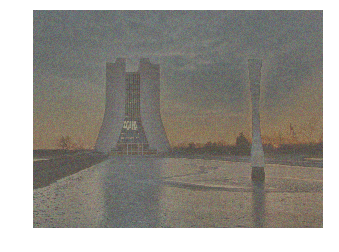

In [58]:
result_image = sess.run(net['input'])
print(result_image.shape)
print(np.min(result_image), np.max(result_image))
print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
imshow_clean(np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))  # 

In [59]:
for i in range(10):
    sess.run(train)
    result_image = sess.run(net['input'])
    print(i, sess.run(cost_total))
    path = out_dir + '/styled_%04d.png' % i
    scipy.misc.imsave(path, np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))

0
6.37463e+11
55.0517311096 174.241294861
1
5.89297e+11
53.3154373169 176.191242218
2
5.48247e+11
51.4770927429 178.14264679
3
5.14444e+11
49.4803123474 180.109020233
4
4.84475e+11
47.4712409973 182.095989227
5
4.55939e+11
45.4454689026 184.09753418
6
4.30033e+11
43.4070625305 186.114269257
7
4.07479e+11
41.3668060303 188.135124207
8
3.87364e+11
39.3350982666 190.143859863
9
3.68903e+11
37.3483581543 192.158744812


In [107]:
print(result_image.shape)
print(np.min(result_image), np.max(result_image))
print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
imshow_clean(np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))  # 

(1, 600, 800, 3)
-72.1452 70.2243
37.2655487061 192.532272339


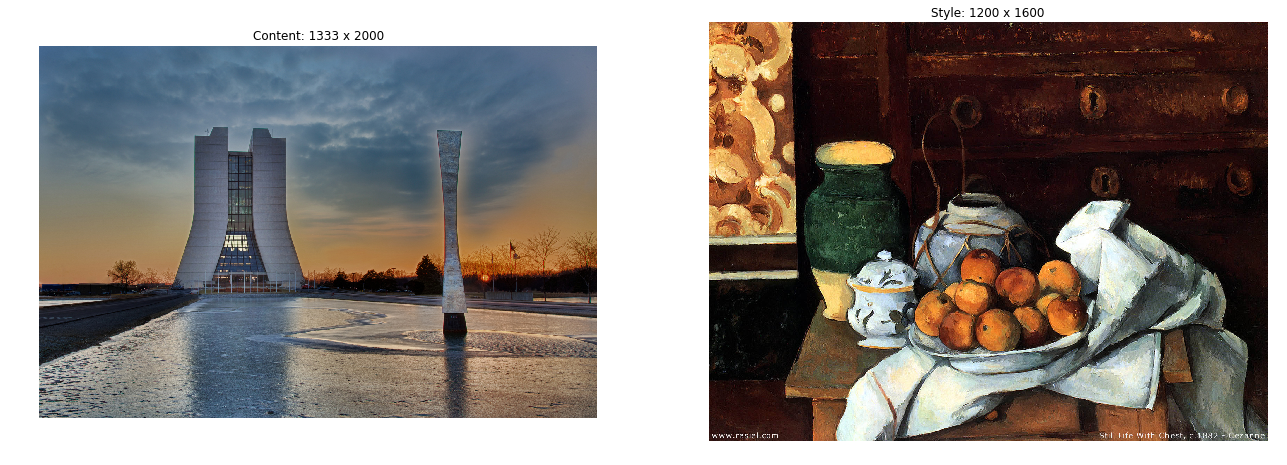

In [60]:
show_img_pair(raw=raw_source, normed=raw_style,  
              raw_title='Content', normed_title='Style', interpolation=None,
              raw_type='uint8', normed_type='uint8')

In [61]:
for i in range(10, 150):
    sess.run(train)
    result_image = sess.run(net['input'])
    print(i, sess.run(cost_total))
    path = out_dir + '/styled_%04d.png' % i
    scipy.misc.imsave(path, np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))

10 3.51783e+11
11 3.35707e+11
12 3.20383e+11
13 3.05776e+11
14 2.91987e+11
15 2.79064e+11
16 2.66919e+11
17 2.55481e+11
18 2.44694e+11
19 2.34566e+11
20 2.25063e+11
21 2.16138e+11
22 2.07733e+11
23 1.99816e+11
24 1.92338e+11
25 1.85276e+11
26 1.78589e+11
27 1.7226e+11
28 1.66262e+11
29 1.60568e+11
30 1.55147e+11
31 1.4998e+11
32 1.45049e+11
33 1.40355e+11
34 1.35885e+11
35 1.31625e+11
36 1.27567e+11
37 1.23703e+11
38 1.20019e+11
39 1.16511e+11
40 1.13175e+11
41 1.09994e+11
42 1.06966e+11
43 1.0408e+11
44 1.0133e+11
45 9.87057e+10
46 9.62005e+10
47 9.38084e+10
48 9.1525e+10
49 8.93385e+10
50 8.72409e+10
51 8.52325e+10
52 8.33089e+10
53 8.14656e+10
54 7.97011e+10
55 7.80085e+10
56 7.63843e+10
57 7.48256e+10
58 7.33277e+10
59 7.18881e+10
60 7.05043e+10
61 6.91747e+10
62 6.78937e+10
63 6.66599e+10
64 6.54704e+10
65 6.43274e+10
66 6.32258e+10
67 6.21635e+10
68 6.11378e+10
69 6.01462e+10
70 5.91884e+10
71 5.82602e+10
72 5.73616e+10
73 5.64913e+10
74 5.56488e+10
75 5.48317e+10
76 5.40399e+10


(1, 600, 800, 3)
-256.04 218.207
-139.039581299 335.206924438


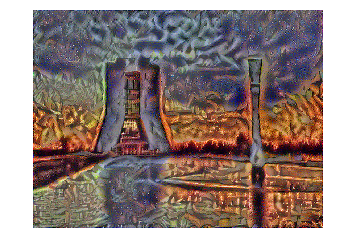

In [62]:
print(result_image.shape)
print(np.min(result_image), np.max(result_image))
print(np.min(result_image + VGG_MEAN_VALUES), np.max(result_image + VGG_MEAN_VALUES))
imshow_clean(np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))  # 

In [63]:
for i in range(150, 300):
    sess.run(train)
    result_image = sess.run(net['input'])
    print(i, sess.run(cost_total))
    path = out_dir + '/styled_%04d.png' % i
    scipy.misc.imsave(path, np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255).astype('uint8'))

150 2.45576e+10
151 2.43365e+10
152 2.41178e+10
153 2.39015e+10
154 2.36873e+10
155 2.34752e+10
156 2.3265e+10
157 2.30571e+10
158 2.28506e+10
159 2.26467e+10
160 2.24448e+10
161 2.22448e+10
162 2.20465e+10
163 2.18501e+10
164 2.16557e+10
165 2.14631e+10
166 2.12727e+10
167 2.10843e+10
168 2.08982e+10
169 2.07141e+10
170 2.05319e+10
171 2.03517e+10
172 2.01729e+10
173 1.99959e+10
174 1.98206e+10
175 1.9647e+10
176 1.94752e+10
177 1.93052e+10
178 1.91368e+10
179 1.89698e+10
180 1.88044e+10
181 1.86404e+10
182 1.84781e+10
183 1.8317e+10
184 1.81573e+10
185 1.79993e+10
186 1.78429e+10
187 1.76875e+10
188 1.75334e+10
189 1.7381e+10
190 1.72301e+10
191 1.70807e+10
192 1.69327e+10
193 1.67863e+10
194 1.66413e+10
195 1.64979e+10
196 1.63556e+10
197 1.62146e+10
198 1.60749e+10
199 1.5936e+10
200 1.57985e+10
201 1.56622e+10
202 1.55268e+10
203 1.53927e+10
204 1.52599e+10
205 1.51281e+10
206 1.49975e+10
207 1.48684e+10
208 1.47406e+10
209 1.4614e+10
210 1.44884e+10
211 1.4364e+10
212 1.42406e+10

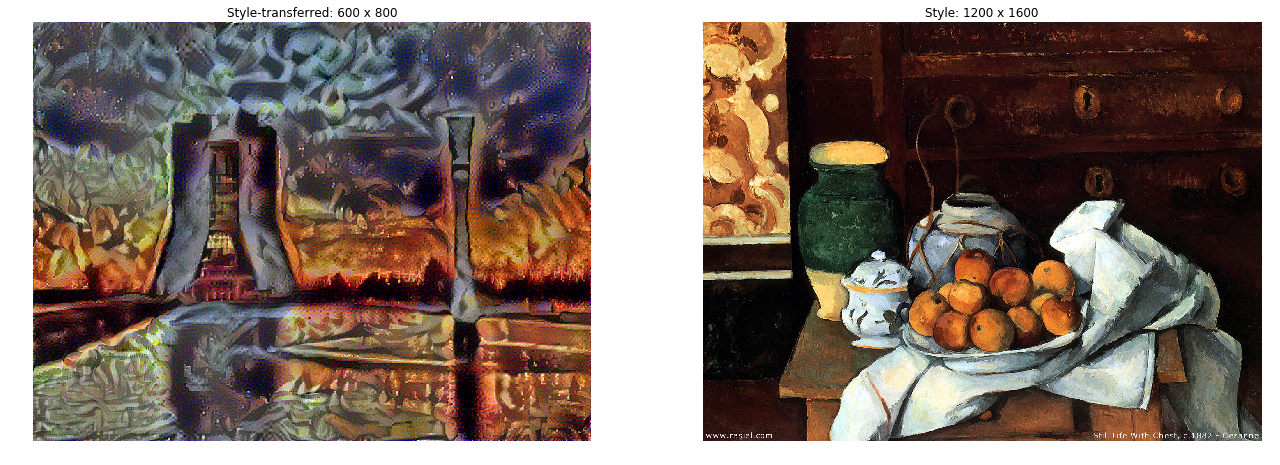

In [66]:
show_img_pair(raw=np.clip((result_image + VGG_MEAN_VALUES)[0], 0, 255), normed=raw_style,  
              raw_title='Style-transferred', normed_title='Style', interpolation=None,
              raw_type='uint8', normed_type='uint8')